<a href="https://colab.research.google.com/github/axiom19/Mitsuba_Render_Tutorial/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mitsuba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.3 MB/s eta 0:00:00


In [2]:
import mitsuba as mi

<h3>Setting the variant of Mitsuba</h3>
<ol><li> Settings have either GPU or CPU usage
<li> scalar or vectorized inputs
<li> Automatic Differentiation or not

In [15]:
mi.variants() # this method shows the available variants which could be used

['scalar_rgb', 'scalar_spectral', 'cuda_ad_rgb', 'llvm_ad_rgb']

In [16]:
mi.set_variant('scalar_rgb') # setting variants to CPU usage rendering with scalar input without automatic differentiation

In [20]:
# loading a preset scene in a dictionary for the box object
print(mi.load_dict(mi.cornell_box()))

Scene[
  children = [
    Rectangle[
      to_world = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, -1],
                  [0, 0, 0, 1]],
      frame = Frame[
        s = [2, 0, 0],
        t = [0, 2, 0],
        n = [0, 0, 1]
      ],
      surface_area = 4,
      bsdf = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [0.885809, 0.698859, 0.666422]
        ]
      ]
    ],
    Rectangle[
      to_world = [[1, 0, 0, 0],
                  [0, -4.37114e-08, -1, 1],
                  [0, 1, -4.37114e-08, 0],
                  [0, 0, 0, 1]],
      frame = Frame[
        s = [2, 0, 0],
        t = [0, -8.74228e-08, 2],
        n = [0, -1, -4.37114e-08]
      ],
      surface_area = 4,
      bsdf = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [0.885809, 0.698859, 0.666422]
        ]
      ]
    ],
    Rectangle[
      to_world = [[1, 0, 0, 0],
                  [0, -4.37114e-08, 1, -1],
          

In [21]:
img = mi.render(mi.load_dict(mi.cornell_box()))

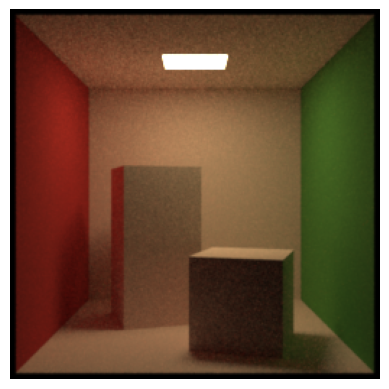

In [22]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping

In [7]:
mi.Bitmap(img).write('cbox.exr')

# Create an object scene Dictionary or load an XML file 
<ul><li>Inegrator : How the light source interacts with object
<li> BSDF : Surface scattering models describe the manner in which light interacts with surfaces in the scene
<li> Emitter : How the light is emitted from the light source (Area , Point Source, Projection Light Source, etc)
<li> Film : A film defines how conducted measurements are stored and converted into the final output file that is written to disk at the end of the rendering process (HDR or Spectral Film)
<li> Participating Media : Media inside or outside the object
<li> Phase Functions


In [10]:
# Create an alias for convenience
from mitsuba import ScalarTransform4f as T

scene = mi.load_dict({
    'type': 'scene',
    # Setting up the integrator
    'integrator': {'type': 'path',
                   'max_depth' : 2},
    'light': {'type': 'constant'},
    # setting source information 
    'bunny': {
        'type': 'ply',
        'filename': 'bunny.ply',
        'face_normals':True,
        'to_world': T.translate([0, 0, -1.5]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {'type': 'rgb', 'value': [0.9, 0.2, 0.3]},
        },
    },
})

In [11]:
## setting up the visual for the sensor
def load_sensor(r, phi, theta):
    # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
    origin = T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, r])

    return mi.load_dict({
        'type': 'perspective',
        'fov': 8.3077,
        'to_world': T.look_at(
            origin=origin,
            target=[0, 0, 0],
            up=[0, 0, 1]
        ),
        'sampler': {
            'type': 'stratified',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 256,
            'height': 256,
            'rfilter': {
                'type': 'gaussian',
                'stddev': 0.2
            },
            'pixel_format': 'rgb',
        },
    })

In [12]:
sensor_count = 6

radius = 0.5
phis = [60.0 * i for i in range(sensor_count)]
theta = 2.0

sensors = [load_sensor(radius, phi, theta) for phi in phis]

In [13]:
# initiating render of object in the scene
images = [mi.render(scene, spp=16, sensor=sensor) for sensor in sensors]

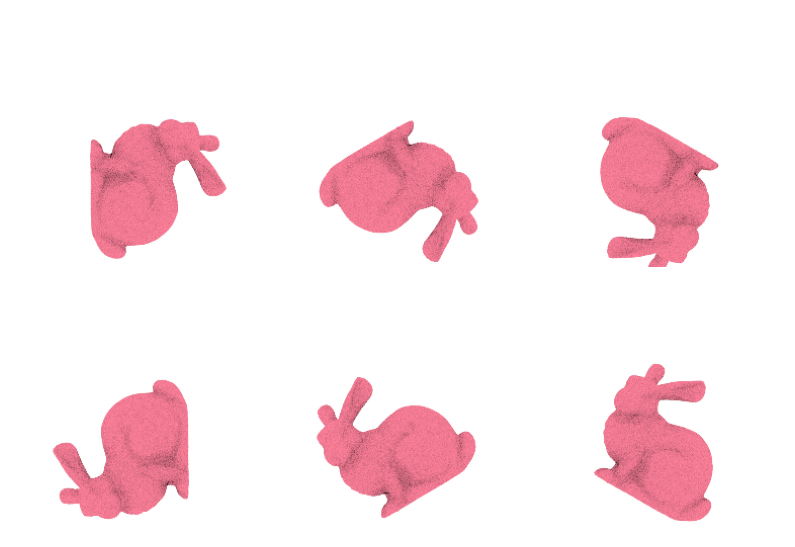

In [14]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(sensor_count):
    ax = fig.add_subplot(2, 3, i + 1).imshow(images[i] ** (1.0 / 2.2))
    plt.axis("off")